# Principal Component Analysis

## Informal Problem Definition
### Motivating Example: Visualization of a Dataset

```{figure} /images/dim_reduction/iris_Pictures.jpg
---
height: 300px
name: Iris 
align: center
---
The Iris dataset describes three Iris types
```


In [1]:
from sklearn import datasets
iris = datasets.load_iris()
D = iris.data
y = iris.target
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

The target variable is ordinal encoded: 

In [2]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

The class names are given in the following list:

In [3]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [4]:
import pandas as pd
df = pd.DataFrame(D)
df.columns = iris.feature_names
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


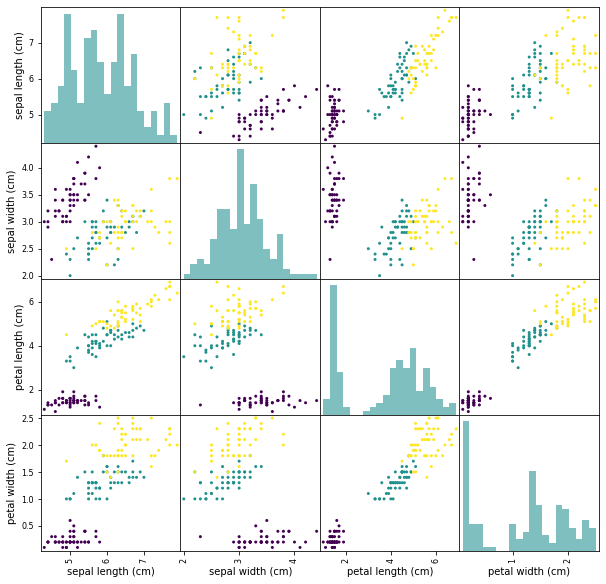

In [5]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
scatter_matrix(df, c =pd.DataFrame(y), figsize=(10,10),  # c : color acording to classes
               hist_kwds={'color':'teal','bins':20, 'alpha':0.5}, alpha=1.)
plt.show()

We can also generate new features based on the existing ones. The new features might capture the important characteristics of the data (here, those would be the classifying characteristics). For example, we could multiply features, or compute a weighted sum of the features.

In [6]:
df_new = df.copy(deep=False)
df_new["sep len*pet len"] = df_new["sepal length (cm)"] + df_new["petal length (cm)"]
df_new["3sep len + 2pet len"] = df_new["sepal length (cm)"] + df_new["petal width (cm)"]
df_new.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),sep len*pet len,3sep len + 2pet len
0,5.1,3.5,1.4,0.2,6.5,5.3
1,4.9,3.0,1.4,0.2,6.3,5.1
2,4.7,3.2,1.3,0.2,6.0,4.9
3,4.6,3.1,1.5,0.2,6.1,4.8
4,5.0,3.6,1.4,0.2,6.4,5.2


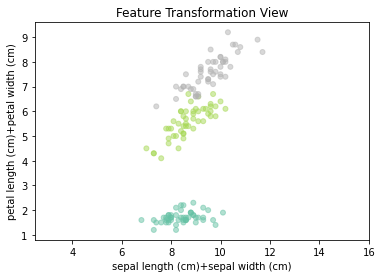

In [7]:
def plot(x_1,x_2, labels=None, title="", xlabel="x", ylabel="y"):
    if labels is None:
        plt.scatter(x_1, x_2, s=25, alpha=0.5, cmap="Set2")
    else:
        plt.scatter(x_1, x_2, c=labels, s=25, alpha=0.5, cmap="Set2")
    #plt.axhline(y=0, color='m', alpha=0.5)
    #plt.axvline(x=0, color='m', alpha=0.5)
    plt.axis('equal')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)


plot(D[:, 0]+D[:, 1], D[:,2]+D[:,3], y, title="Feature Transformation View", xlabel= iris.feature_names[0]+"+"+iris.feature_names[1], ylabel= iris.feature_names[2]+"+"+iris.feature_names[3])


So, in this example, the two-dimensional view on the data gives us some information about the separability of the classes. The question is just how we can maximize the information captured in the low-dimensional view. For that, we need a computable definition of _information_. A reasonable definition could be for example the variance that is captured in the low-dimensional view. Usually, the directions along which the data spreads out the most, can be considered as the directions where the most happens. Of course, this is only the case if the features have comparable units, like in the iris data where each feature is measured in cm. 

So, informally, we want to find a small set of newly created features 

### Motivating Example 2: Visualization of a Synthetic Data Set
At this point, it's maybe not really clear what we want yet. We want a good view on the data but what is that supposed to mean? Let's create an artificial example where we know what we put in and what we want to get out. We create a dataset that is well-separable in 2 dimensions and then extend this data to three dimensions.

The two-dimensional dataset looks as follows:

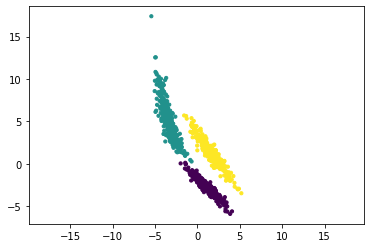

In [8]:
import numpy as np
def generate2dClassData(epsilon,n):
    # Anisotropicly distributed data
    A, labels = datasets.make_blobs(n_samples=n, cluster_std=epsilon*np.array([0.8,1.2,1.1]), random_state=176)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    A = np.dot(A, transformation)
    A[labels==1,1] = 0.1*A[labels==1,1]**2 
    angle = 10
    theta = (angle/180.) * np.pi

    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta),  np.cos(theta)]])
    A[labels==1,:] = A[labels==1,:]@R
    angle = -10
    theta = (angle/180.) * np.pi

    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta),  np.cos(theta)]])
    A[labels==0,:] = A[labels==0,:]@R
    return A, labels
n=1000
D2d, labels = generate2dClassData(1.5,n)
fig = plt.figure()
ax = plt.axes()
ax.axis('equal')
ax.scatter(D2d[:, 0], D2d[:, 1], c=labels, s=10)

We see that the classes, which have each their own color, are quite well separated. Now we extend this dataset to 3 dimensions by adding a third column to the dataset which contains Gaussian noise.

In [9]:
def plot3dProjections(D,labels):
    X=D[:,0]
    Y=D[:,1]
    Z=D[:,2]

    plt.figure( figsize=(13, 5))
    ax1 = plt.subplot(121,  projection='3d')

    ax1.scatter(X, Y, Z, c=labels, s=10)
    ax1.set_xlabel('X - axis')
    ax1.set_ylabel('Y - axis')
    ax1.set_zlabel('Z - axis')

    ax2 = plt.subplot(122,  projection='3d')

    cx = np.ones_like(X) * ax1.get_xlim3d()[0]
    cy = np.ones_like(X) * ax1.get_ylim3d()[1]
    cz = np.ones_like(Z) * ax1.get_zlim3d()[0]

    ax2.scatter(X, Y, cz, c=labels,  lw=0, alpha=0.2)
    ax2.scatter(X, cy, Z, c=labels, lw=0, alpha=0.2 )
    ax2.scatter(cx, Y, Z, c=labels, lw=0, alpha=0.2)
    ax2.set_xlim3d(ax1.get_xlim3d())
    ax2.set_ylim3d(ax1.get_ylim3d())
    ax2.set_zlim3d(ax1.get_zlim3d())
    ax2.set_box_aspect([1.0, 1.0, 1.0])
    ax2.set_xlabel('X - axis')
    ax2.set_ylabel('Y - axis')
    ax2.set_zlabel('Z - axis')

In [10]:
def generate3dClassData(A,labels):
    s = np.random.normal(0, 0.8, A.shape[0])
    s[labels==2] = s[labels==2]*1.4
    A = np.hstack([A,s[:,None]])    
    return A, labels

D3d, labels = generate3dClassData(D2d,labels)

When we plot the data in a 3D plot together with the projections on each pair of features, we recognize our 2D data in the projection on the X-Y axis. 

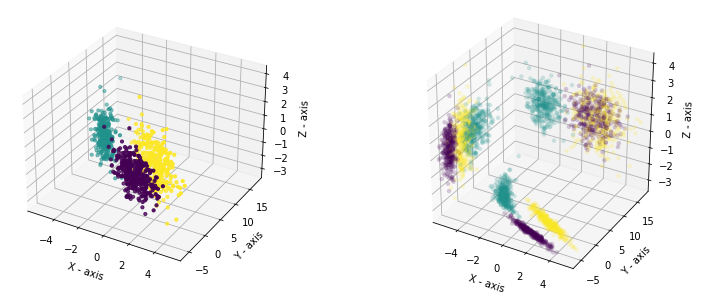

In [11]:
plot3dProjections(D3d,labels)

In general we cannot expect that the nicest view on the data is aligned with a selection of the axes. Hence, we rotate our 3D data to distort the two-dimensional views.

In [12]:
from scipy.spatial.transform import Rotation as Rt
D3d, labels = generate3dClassData(D2d,labels)
R = Rt.from_euler('zyx', [140, 145, 145], degrees=True)
D3d = D3d@R.as_matrix()

The 3D plot and the projections look now like this:

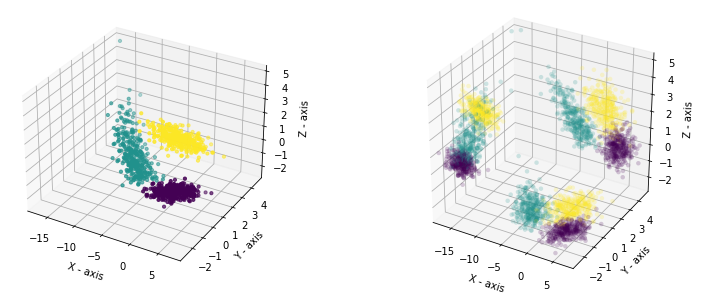

In [13]:
plot3dProjections(D3d,labels)

If we make a scatterplot matrix for the dataset, we get the following views. The data looks not so clearly separable anymore.

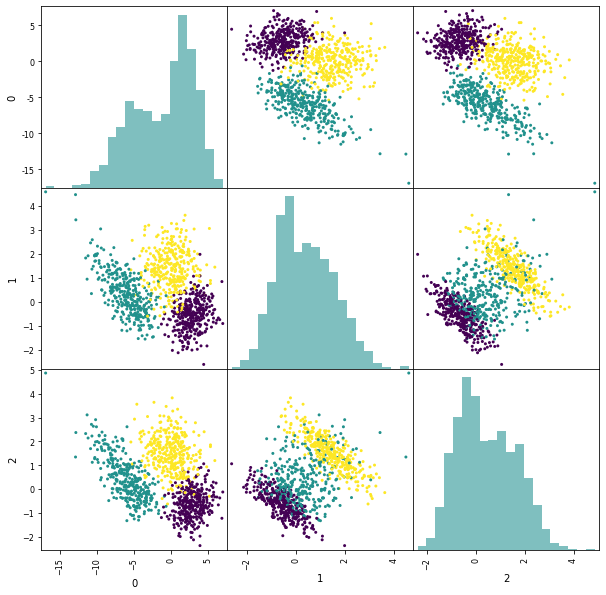

In [14]:
scatter_matrix(pd.DataFrame(D3d), c =pd.DataFrame(labels), figsize=(10,10),  # c : color acording to classes
               hist_kwds={'color':'teal','bins':20, 'alpha':0.5}, alpha=1.)
plt.show()

So, what we would like in this example is to find the direction along which we added the noise, and remove it, because this direction is not informative for the classification. Now the question is how we define the not-so informative directions. One way is to remove those directions along which not much is happening in the data. That are those directions along which the variance in the data is small. 

## Formal Problem Definition
Informally, we want to remove the directions along which the data has a low variance. In reverse, we could say that we want to find a low-dimensional subspace in which the data keeps most of its variance. To formalize this idea, we need to know how we can define subspaces mathematically. Or, what it means to find and remove a direction. 
### Indicating a Direction and Projecting the Data Onto that Direction
Mathematically, a direction can be indicated by a vector. For example, the direction onto the Z-axis is given by the vector $(0,0,1)$. From the linear arlgebra recap, you might remember that a projection onto a vector is given by the inner product with a vector of norm one. That means that if we want to project our data onto a direction, then we need to multiply the data points with a vector pointing in that direction, having norm one.     

Given the $n\times d$ data matrix $D$ gathering $n$ observations of $d$ features $\mathtt{F}_1,\ldots,\mathtt{F}_d$, we define a new feature as
\begin{align}\mathtt{F}_{d+1}= \sum_{k=1}^d \alpha_k\mathtt{F}_k.\end{align}
We have $n$ observations of this new feature, given by
\begin{align}D_{\cdot d+1} =\sum_{k=1}^d \alpha_kD_{\cdot k}=D\bm\alpha\in\mathbb{R}^n\end{align}
That means that the $i$-th feature value of the new feature is computed by the inner product $D_{i\cdot}\alpha$ of the $i$-th observation and the coefficient vector $\alpha$. We can write the inner product $D_{i\cdot}\alpha = D_{i\cdot} \frac{\alpha}{\lVert\alpha\rVert}\lVert\alpha\rVert$ as the inner product of vector $D_{i\cdot}$ and the unit norm vector $\frac{\alpha}{\lVert\alpha\rVert}$, multiplied with the scalar $\lVert\alpha\rVert$. Geometrically, this inner product describes a projection of the vector $D_{i\cdot}$ onto the vector $\frac{\alpha}{\lVert\alpha\rVert}$, scaled with the norm $\lVert\alpha\rVert$. Let's explore this by an example. We create an example dataset which has teh shape of a multivariate Gaussian.

In [15]:
import numpy as np
mean = [10,20]
cov = [[20,10],[10,10]]
n=500

x1,x2 = np.random.multivariate_normal(mean,cov,n).T
D = np.c_[x1,x2]
dfD = pd.DataFrame(data =D,columns = ["$F_1$","$F_2$"])
dfD.head()

,$F_1$,$F_2$
0,8.826704,17.398124
1,15.323024,22.687349
2,12.570316,19.422429
3,6.263352,16.244030
4,11.256114,19.910695


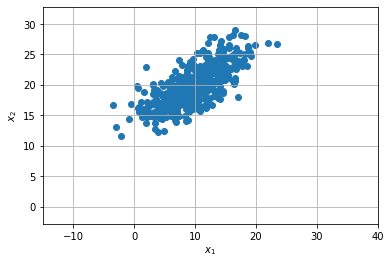

In [16]:
#define plotting environment
def pcaPlot(): 
    plt.axis('equal')
    plt.xlim(-15.0,40.0)
    plt.ylim(-10.0,40.0)
    plt.grid()
pcaPlot()

plt.scatter(D[:,0],D[:,1])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

We choose a vector $\alpha$, creating a new feature $F_a = \alpha_1F_1+\alpha_2F_2$, having observations $D_{\cdot a} = D\alpha$. 

In [17]:
α = np.array([1,2])
#α=α/np.linalg.norm(α)
print("α=",α)
dfD_a = pd.DataFrame({"$x_a$":D@α})
dfD_a.head()

α= [1 2]


,$x_a$
0,43.622951
1,60.697722
2,51.415174
3,38.751412
4,51.077504


We plot the data and the direction onto which $\alpha$ points by the red vector.

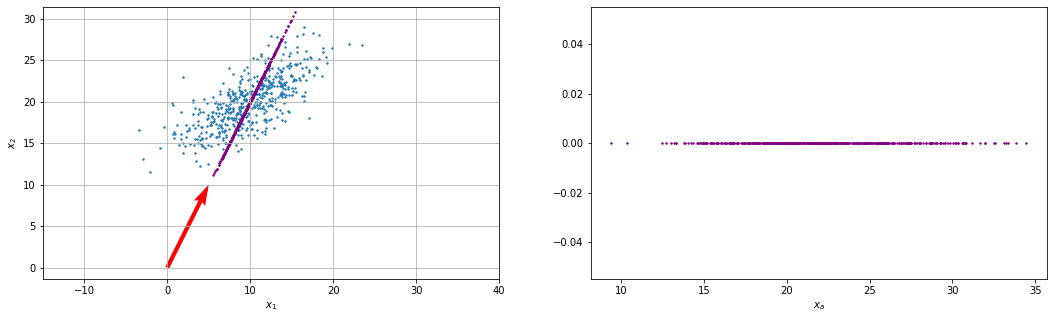

In [18]:
P = np.outer(D@α,α)/(np.linalg.norm(α)**2)
plt.figure(2, figsize=(18, 5))
#--------------
plt.subplot(1,2,1)
pcaPlot()
plt.scatter(D[:,0],D[:,1], s=2)
plt.scatter(P[:,0],P[:,1], color = 'purple', s=2) 
plt.quiver(0, 0, 5*α[0],5*α[1] , units='xy', width=0.5, scale=1, color='red')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
#----------------
plt.subplot(1,2,2)
plt.scatter(D@α/np.linalg.norm(α), np.zeros(D.shape[0]), color ="purple", s=2)
plt.xlabel("$x_a$")
plt.show()

In [19]:
#!pip3 install JSAnimation
from JSAnimation import IPython_display
from matplotlib import animation
from IPython.display import HTML
def animatePCA(i):
    ax.cla()#clear axes
    ax.axis('equal')
    ax.grid()
    global α,D,R
    if i>0: α=R@α
    ax.scatter(D[:,0],D[:,1], s=2)
    P = np.outer(D@α,α)
    ax.scatter(P[:,0],P[:,1], color = 'purple', s=2) 
    ax.quiver(0, 0, 10*α[0],10*α[1] , units='xy', width=0.5, scale=1, color='red')
    return
fig = plt.figure()
ax = plt.axes()
theta =np.pi/20
R = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
α=np.array([1,0])
anim = animation.FuncAnimation(fig, animatePCA, frames=100, interval=200, blit=False)
plt.close()
HTML(anim.to_jshtml())

### Defining the PCA Task
`````{admonition} Task (Principle Component Analysis)
:class: tip
**Given** a data matrix $D\in\mathbb{R}^{n\times d}$ and a rank $r$, denoting the number of dimensions available for.       

**Find** the $r$ orthogonal direction of largest variance, given by the columns $Z_{\cdot s}$ which are the solution to the following series of optimization problems:
\begin{align}
    \max\ & \mathrm{var}(DZ_{\cdot 1}) \\
    &\text{s.t. } \lVert Z_{\cdot 1}\rVert^2=1\\
    \max\ & \mathrm{var}(DZ_{\cdot 2}) \\
    &\text{s.t. } \lVert Z_{\cdot 2}\rVert^2=1,\ Z_{\cdot 1}^\top Z_{\cdot 2}=0 \\
    &\vdots\\
    \max\ & \mathrm{var}(DZ_{\cdot r}) \\
    &\text{s.t. } \lVert Z_{\cdot r}\rVert^2=1,\ Z_{\cdot s}^\top Z_{\cdot r}=0 \text{ for } 1\leq s\leq r\\
\end{align}
**Return** the directions of largest variance $Z$ 
`````

We compute the sample mean as
\begin{align}
    \mu_{\mathtt{F}_{d+1}} &= \frac1n \sum_{i=1}^n D_{i d+1}
    = {\bm \mu_\mathtt{F}^\top \alpha},
    &\text{ where }\bm\mu_\mathtt{F} = \begin{pmatrix}
  \mu_{\mathtt{F}_1}\\ \vdots \\ \mu_{\mathtt{F}_d}
\end{pmatrix}
\end{align}
is the vector gathering all sample means for the $d$ features.

We compute the **sample variance** as 
\begin{align}
    \sigma_{\mathtt{F}_{d+1}}^2 &=\frac1n\sum_{i=1}^n (D_{id+1}-\mu_{\mathtt{F}_{d+1}})^2
    =\frac1n\left\lVert \left(D -\vvec{1}{\bm \mu_\mathtt{F}^\top }\right){\bm\alpha}\right\rVert^2
\end{align}
We are interested in the direction of maximal variance, so we can restrict the length of vector $\bm{\alpha}$: $\lVert\bm{\alpha}\rVert=1$

The direction of largest variance ${\bm\alpha}$ is the solution to the following optimization problem:
\begin{align}
    \max_{\lVert \bm{\alpha}\rVert=1}\sigma_{d+1}^2
&=\max_{\lVert \bm{\alpha}\rVert=1}
\frac1n\left\lVert \left(D-\vvec{1}{\bm\mu_\mathtt{F}^\top}\right){\bm\alpha}\right\rVert^2 \\
&= \max_{\lVert \bm{\alpha}\rVert=1} \frac1n {\bm\alpha}^\top \left(D-\vvec{1}{\bm\mu_\mathtt{F}^\top}\right)^\top \left(D-\vvec{1}{\bm\mu_\mathtt{F}^\top}\right){\bm\alpha}\\
&=\max_{\lVert \bm{\alpha}\rVert=1} \frac{{\bm\alpha}^\top C^\top C{\bm\alpha}}{n},
\end{align}
where $C=D-\vvec{1}{\bm\mu_\mathtt{F}^\top}$ is the centered data matrix.    

So, the direction of largest variance is given by the operator norm of the centered data matrix. 

How can we derive a low-dimensional representation of the data?

Find the $r$ orthogonal directions of largest variance.    


## Optimization
If $C=U\Sigma V^\top$ is the SVD of the centered data matrix $C$, then the solution to PCA is given by truncated SVD:
\begin{align}
    Y &= U_{\cdot \mathcal{K}}\Sigma_{\mathcal{K}\mathcal{K}} &\text{ (new coordinates)},\\ 
    X& =V_{\cdot \mathcal{K}} &\text{ (Principal Components)}
\end{align}

```{prf:algorithm} PCA

**Input**: $D, r$
1. $C\gets D-\vvec{1}{\bm\mu_\mathtt{F}^\top}$  #Center the data matrix
2. $(U_{\cdot \mathcal{R}},\Sigma_{\mathcal{R} \mathcal{R}},V_{\cdot \mathcal{R}})\gets$ `TruncatedSVD`${C,r}$
3. **return** $CV_{\cdot \mathcal{R}}$ (the low-dimensional view on the data)
```

PCA can be implemented such that the low-dimensional data representation is centered (returning $CV_{\cdot \mathcal{R}}$) or not (returning $DV_{\cdot \mathcal{R}}$).

## Alternative Definitions of the PCA Objective*

Alternative objective for PCA, subspace-based:   
**Find**
the $r$ orthogonal basis vectors, given by the columns $Z_{\cdot s}$, which span an $r$-dimensional subspace in which the most 
\begin{align}
    \max_{Z}& \tr(Z^\top C^\top C Z) & \text{s.t. } Z\in\mathbb{R}^{d\times r},\ Z^\top Z =I
\end{align}
where $C=D-\vvec{1}{\bm\mu_\mathtt{F}^\top}$ is the centered data matrix.
